In [13]:
import numpy
import scipy
import seaborn
import pandas
import struct
import matplotlib.pyplot as plt
%matplotlib ipympl

In [14]:
plt.close()

In [15]:
data_path = "data/"

In [16]:
# open file
filename = data_path + 'signal_50MHz.bin'
with open(filename, "rb") as file:
    binary_data = file.read()

#parse binary to float array
char_size = 4
num_characters = len(binary_data) // char_size
format_string = '<'+str(num_characters)+'f' # float 
signal = struct.unpack(format_string, binary_data)

# convert the whole thing to numpy array for easy processing
signal = numpy.array(signal)

In [17]:
# keep an untouched version of the signal
original_signal  = signal

In [18]:
# remove constant 
signal = signal - numpy.average(signal)

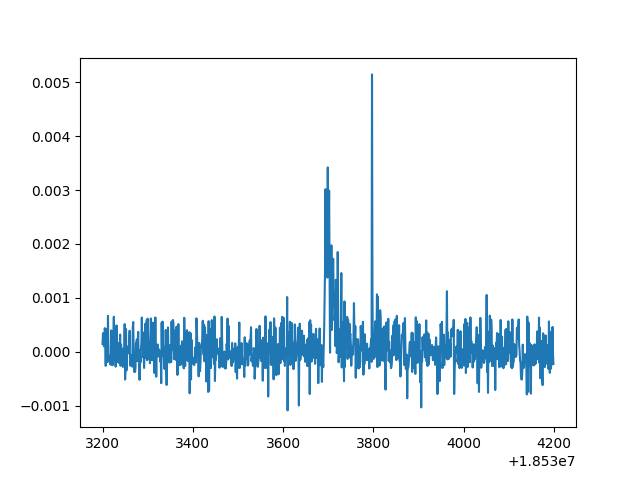

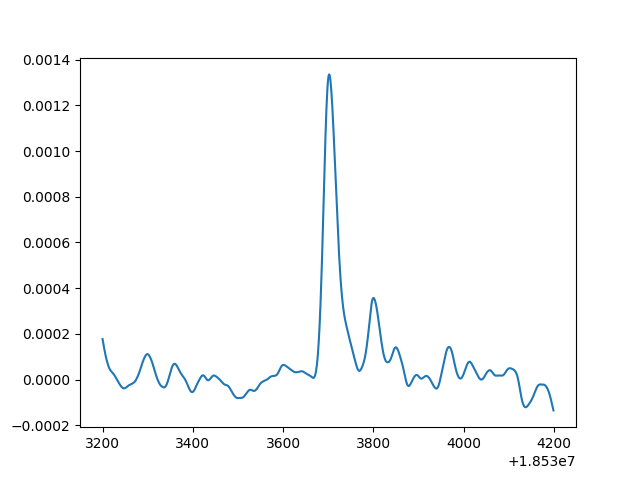

In [19]:
# test for optimal filter parameters

# low pass to remove very short spikes
length = 500
position = 18533700 # very weird small peak 
#position = 67650 # very "normal" peak
#position = 1795945 # kinda low peak
#position = 9121329
#position = 1795952

fs = 50 *1e6

test_sig = signal[position-length:position+length]
plt.figure()
plt.plot(list(range(position-length, position+length)), test_sig)
plt.show()
b, a = scipy.signal.butter(2, 1 * 1e6, "low", fs=fs)
low_passed = scipy.signal.filtfilt(b, a, test_sig)
plt.figure()
plt.plot(list(range(position-length, position+length)), low_passed)
plt.show()

In [20]:
# filter whole signal 
low_passed = scipy.signal.filtfilt(b, a, signal)

In [21]:
# find peaks 
noise_level = numpy.average(numpy.abs(low_passed))
peaks_low_passed, peak_properties_low_passed = scipy.signal.find_peaks(low_passed, prominence=40*noise_level, distance=None, width=None, height=None)

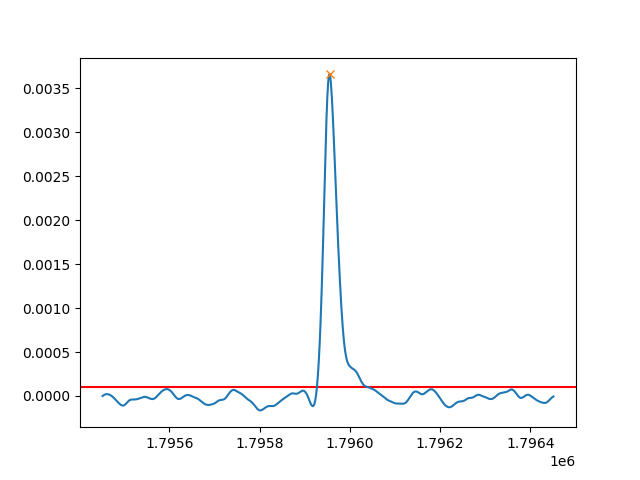

In [22]:
# plot found peaks with processed signal for debugging 

# test for optimal filter parameters

# low pass to remove very short spikes
length = 500
#position = 18533700 # very weird small peak 
#position = 67650 # very "normal" peak
#position = 1795945 # kinda low peak
#position = 9121329 # very sttep attack
position = 1795952 # very low peak

test_sig = low_passed[position-length:position+length]
test_peaks = peaks_low_passed
test_peaks = test_peaks[(test_peaks[:]>=position-length) & (test_peaks[:]<position+length)]
plt.figure()
plt.axhline(y = 2 * noise_level, color = 'r', linestyle = '-') 
plt.plot(list(range(position-length, position+length)), test_sig)
plt.plot(test_peaks, test_sig[test_peaks-position-length], "x")
plt.show()

In [23]:
# refine peak positions
search_area = 10
peaks_refined = []
for p in peaks_low_passed:
    signal_slice = signal[p-search_area:p]
    i = numpy.argmax(signal_slice)
    peaks_refined.append(p - (len(signal_slice) - i))

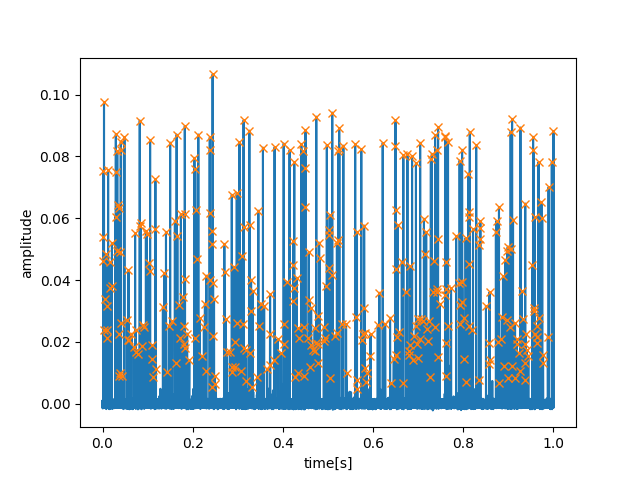

In [26]:
# plot whole signal with refined peaks
t = numpy.divide(numpy.array(range(0, len(signal))), 50*1e6)

plt.figure()
plt.plot(t, signal)
plt.plot(t[peaks_refined], signal[peaks_refined], "x")
plt.xlabel("time[s]")
plt.ylabel("amplitude")
plt.show()

In [25]:
# save data for further processing
numpy.save(data_path + "signal", original_signal)
numpy.save(data_path + "peaks", peaks_refined)